# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# append project root to sys.path to import modules
# alternatively package the application and install with pip install --editable
from pathlib import Path
import sys
project_dir = str(Path.cwd().parent)

for d in [project_dir, '/Users/Tom/Dropbox/workspace/faillissementsdata_db']:
    if d not in sys.path:
        print('adding %s' % d)
        sys.path.append(d)
print(sys.path)

adding /Users/Tom/Dropbox/datascience/_thesis/is-ds-thesis
adding /Users/Tom/Dropbox/workspace/faillissementsdata_db
['', '/Users/Tom/Dropbox/datascience/_thesis/is-ds-thesis/venv/lib/python36.zip', '/Users/Tom/Dropbox/datascience/_thesis/is-ds-thesis/venv/lib/python3.6', '/Users/Tom/Dropbox/datascience/_thesis/is-ds-thesis/venv/lib/python3.6/lib-dynload', '/Users/Tom/.pyenv/versions/3.6.3/lib/python3.6', '/Users/Tom/Dropbox/datascience/_thesis/is-ds-thesis/venv/lib/python3.6/site-packages', '/Users/Tom/Dropbox/datascience/_thesis/is-ds-thesis/venv/lib/python3.6/site-packages/IPython/extensions', '/Users/Tom/.ipython', '/Users/Tom/Dropbox/datascience/_thesis/is-ds-thesis', '/Users/Tom/Dropbox/workspace/faillissementsdata_db']


In [3]:
#import pdb; pdb.set_trace()
%matplotlib inline  
# connection to the database
import os
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

# set username/password here:
db = {'username': os.environ['DB_QIR_USERNAME'],
      'password': os.environ['DB_QIR_PASSWORD'],
      'host': 'www.quantleap.nl',  
      'catalog': 'qir'}

con = 'postgresql://{username}:{password}@{host}/{catalog}'.format(**db)
engine = create_engine(con, echo=True)

# create a configured "Session" class and create session
Session = sessionmaker(bind=engine)
session = Session()

# psycopg connection
conn = psycopg2.connect(con)

print('CONNECTION ESTABLISHED')

CONNECTION ESTABLISHED


In [4]:
import datetime
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set()  # apply the default default seaborn theme, scaling, and color palette.
from app.model.process import *


In [14]:
# set pandas display options
pd.set_option('max_colwidth', 150)
pd.set_option('display.max_rows', 100)
pd.set_option('precision', 2)

# Process Mining

We can mine the insolvency process using CIR data by tracking certain events on the timeline:
- court publications
- data changes such as the replacement of administrator
- information from the progress report although the corresponding date can only be approximated

## Court publications
Court publications offer import process information and use a code for each category. For insolvencies the publication frequency of each publication category is given below:

In [15]:
df = publication_type_codes_count()
df

,type_code,count,description
0,1300,42934,uitspraak faillissement op {datum_handeling}
1,1328,29808,vervanging rechtercommissaris
2,1316,25431,opheffing faillissement wegens gebrek aan baten op {datum_handeling}
3,1317,7378,einde faillissement door verbindende uitdelingslijst op {datum_handeling}
4,1307,5365,vervanging curator {naam_oude_cur} door {naam_nieuwe_cur}
5,1323,3572,rectificatie
6,1313,3382,neerlegging slotuitdelingslijst vanaf {datum_variabel}
7,1308,3140,vereenvoudigde afwikkeling van het faillissement
8,1306,2863,uitspraak faillissement na beëindiging surseance op {datum}
9,1315,2111,vereenvoudigde afwikkeling van het faillissement en neerlegging slotuitdelingslijst vanaf {datum_variabel}


### in and outflow of insolvencies

In [31]:
from cir.publication import insolvency_F_start_codes, insolvency_F_end_codes

df_in = df[df['type_code'].isin(insolvency_F_start_codes)]
df_in

,type_code,count,description
0,1300,42934,uitspraak faillissement op {datum_handeling}
8,1306,2863,uitspraak faillissement na beëindiging surseance op {datum}
18,1100,126,uitspraak faillissement in hoger beroep op {datum_handeling}
25,1304,6,heropening faillissement door ontbinding akkoord in faillissement op {datum}
27,1301,3,uitspraak faillissement door tussentijdse beëindiging schuldsanering op {datum}


In [33]:
df_out = df[df['type_code'].isin(insolvency_F_end_codes)]
df_out

,type_code,count,description
2,1316,25431,opheffing faillissement wegens gebrek aan baten op {datum_handeling}
3,1317,7378,einde faillissement door verbindende uitdelingslijst op {datum_handeling}
15,1320,315,vernietiging faillissement na verzet op {datum_handeling}
17,1318,144,einde faillissement door goedkeuring akkoord op {datum_handeling}
19,1102,91,vernietiging faillissement in hoger beroep op {datum_handeling}
20,1319,37,einde faillissement door verbindende uitdelingslijst na verzet op {datum_handeling}
23,1333,8,Faillissement omgezet in SSR op
24,1324,6,einde faillissement door voldoen van alle schulden op {datum_handeling}
26,1202,4,vernietiging faillissement in cassatie op {datum_handeling}


In [73]:
flows = df_in['count'].append(-1 * df_out['count'])
type_codes = df_in['type_code'].append(df_out['type_code'])
descriptions = df_in['description'].append(df_out['description'])
total = df_in['count'].sum()

['1300',
 '1306',
 '1100',
 '1304',
 '1301',
 '1316',
 '1317',
 '1320',
 '1318',
 '1102',
 '1319',
 '1333',
 '1324',
 '1202']

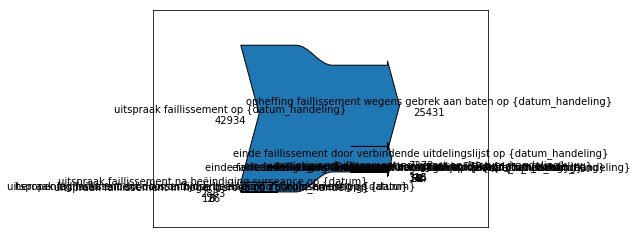

In [84]:
# sankey diagram to show in and outflow of insolvencies
from matplotlib.sankey import Sankey

sankey = Sankey(scale=1/total, offset=0.2, head_angle=150)
sankey.add(flows=flows,
           labels=list(descriptions), 
           orientations=[0] * len(flows),
           pathlengths=[0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25])
diagrams = sankey.finish()

# Rectifications




## Determination of the insolvency start date 
### From Publication
Certain publication codes and descriptions indicate a start date of the insolvency. 

Examples:
- '1300': 'uitspraak faillissement op ...'
- '1301': 'uitspraak faillissement door tussentijdse beëindiging schuldsanering op ...'
- '1302': 'uitspraak faillissement tijdens schuldsanering op ...'
- '1303': 'uitspraak faillissement door ontbinding akkoord in schuldsanering op ...'

all start codes = ['1100', '1200', '1300', '1301', '1302', '1303', '1304', '1305', '1306', '3313']

### Alternative sources
- earliest start date on administrator_receiver
- earliest start date on addresses_insolvent
- earliest start date on addresses_business_name

### Completeness insolvency start date

In [8]:
insolvency_start_date_completeness(only_active=True, cutoff_date=date(2005, 1, 1))

{'with_start_date': 16116, 'without_start_date': 0, 'completeness': 1.0}


# Bankruptcies over time

## New bankruptcies

In [9]:
from app.model.process import insolvency_start_date_count
from datetime import date

s = insolvency_start_date_count().resample('M').sum()

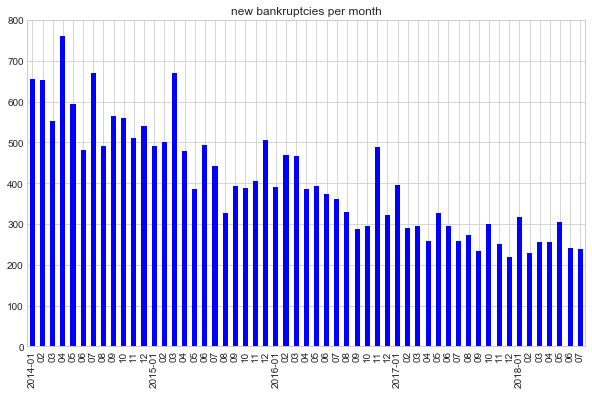

In [10]:
fig = plot_insolvency_start_date_count(s)